In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./ga_dataset.csv')

In [3]:
df.head()

,Device Category,In-Market Segment,Affinity Category (reach),Day of Week,Source / Medium,Avg. % Conversion Probability,Avg. Session Duration,New Users,Sessions,Avg. Order Value,Avg. QTY
0,desktop,Business Services/Advertising & Marketing Serv...,Sports & Fitness/Sports Fans/American Football...,1,mall.googleplex.com / referral,20.1,0:05:50,4,13,$183.88,1.71
1,desktop,Business Services/Advertising & Marketing Serv...,News & Politics/Avid News Readers,0,mall.googleplex.com / referral,19.8,0:03:17,3,10,$32.76,1.17
2,desktop,Home & Garden/Home Furnishings,News & Politics/Avid News Readers,1,mall.googleplex.com / referral,19.3,0:05:08,3,13,$423.18,16.60
3,desktop,Business Services/Advertising & Marketing Serv...,News & Politics/Avid News Readers/Avid Politic...,0,mall.googleplex.com / referral,18.8,0:04:08,3,12,$44.75,1.00
4,desktop,Business Services/Advertising & Marketing Serv...,Food & Dining/Cooking Enthusiasts/Aspiring Chefs,1,mall.googleplex.com / referral,18.4,0:01:57,3,11,$0.00,0.00


In [4]:
# Converting average order value to float
df['Avg. Order Value'] = df['Avg. Order Value'].str.replace('$','', regex=True).astype(float)

# Convert session duration into integer (seconds)
df['session_seconds'] = df['Avg. Session Duration'].str.split(':').apply(lambda x: int(x[1]) * 60 + int(x[2]))

In [5]:
# Checking for null entries
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [6]:
# Checking for values that are 0
df.isin([0]).sum()[df.isin([0]).sum() > 0]

Day of Week                      2412
Avg. % Conversion Probability       7
Avg. Order Value                 6884
Avg. QTY                         6884
dtype: int64

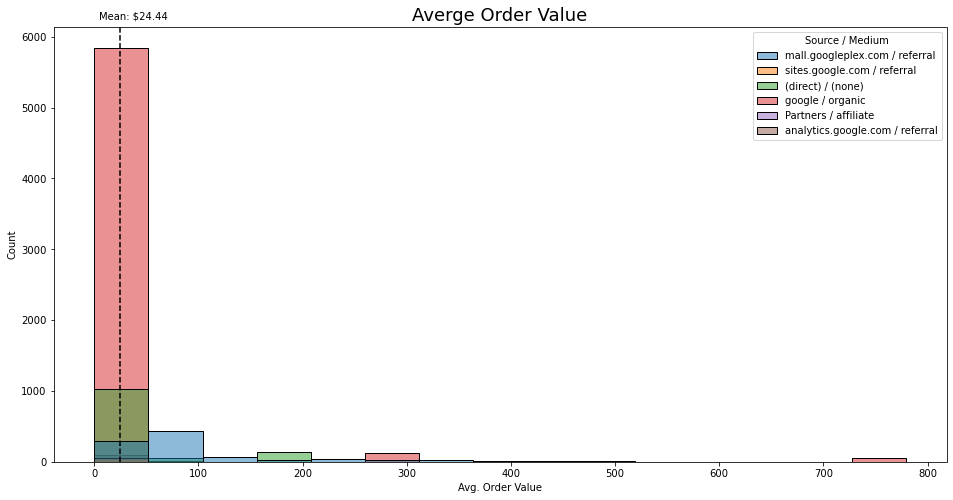

In [7]:
# There's a lot of orders that have a value of 0 (no order placed)
plt.figure(figsize=(16,8))
mean = df['Avg. Order Value'].mean()
sns.histplot(data=df, x='Avg. Order Value', hue='Source / Medium')
plt.text(5,6250, f'Mean: ${mean:.2f}')
plt.axvline(mean, color='black', ls='--', label=f'Mean Value: ${mean:.2f}')
plt.title('Averge Order Value', fontsize=18);

In [8]:
df[df['Avg. Order Value'] == 0].shape

(6884, 12)

In [9]:
df[df['Avg. Order Value'] > 0].shape

(1502, 12)

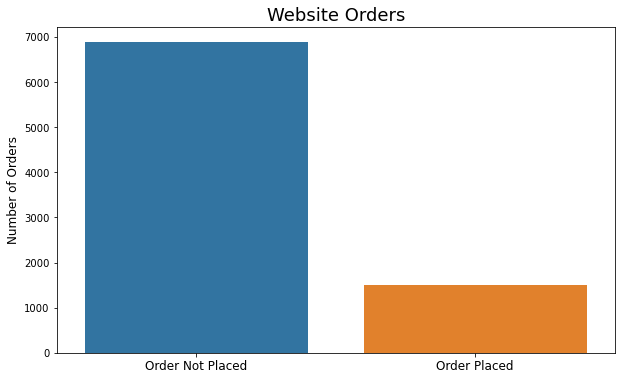

In [10]:
# We can visualize this by looking at a bar chart
df['order_placed'] = df['Avg. Order Value'].apply(lambda x: 1 if x > 0 else 0)
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='order_placed')
plt.xticks(ticks=[0, 1], labels=['Order Not Placed', 'Order Placed'], fontsize=12)
plt.xlabel('')
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Website Orders', fontsize=18);

In [11]:
# Roughly 1 in 5 users place an order when visiting the store
len(df[df['Avg. Order Value'] > 0]) / len(df[df['Avg. Order Value'] == 0])

0.21818710052295176

## Histograms of Numeric Features

In [12]:
# Custom function for plotting of numeric features
def eda_histograms(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/2)) 
    ncols = 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10, nrows*3)) 
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): 
        sns.histplot(data=dataframe, x=dataframe[column], kde=True, ax=ax[i], fill=False)
        ax[i].set_title(column,fontsize=14)
        ax[i].set_xlabel('')
        ax[i].tick_params(labelsize=10)
    plt.tight_layout(h_pad=-0.4, w_pad=-0.4)
    
    for i in range(nrows * ncols - len(list_of_columns)):
        ax[-i-1].set_visible(False) # Hide unused columns
    
    plt.suptitle('Histograms of Numeric Features', fontsize=18)
    plt.tight_layout()

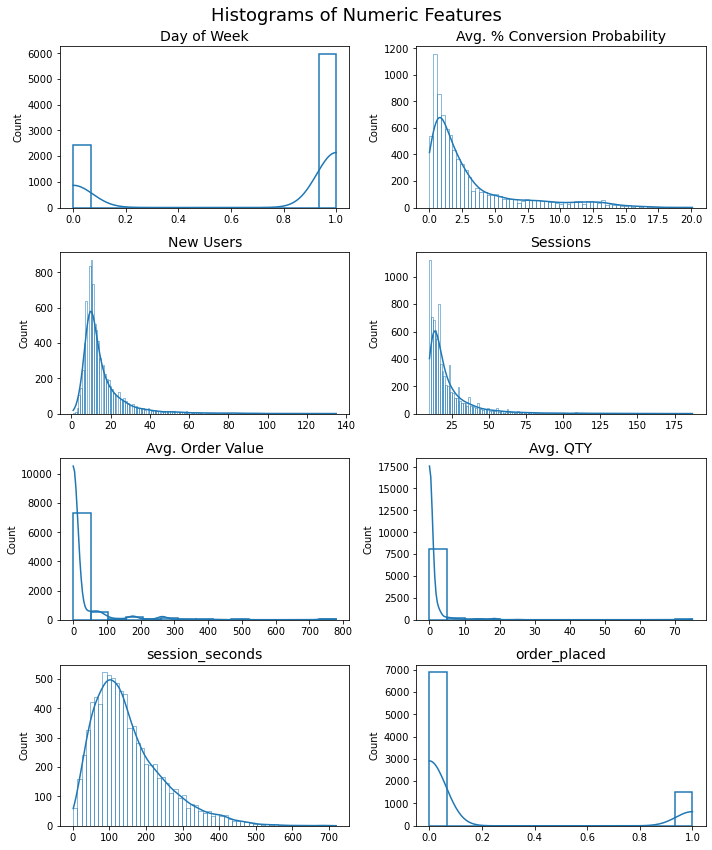

In [13]:
# These are continuous variables -- some of them have a normal distribution, while some are extremely skewed to the right.
eda_histograms(df, df._get_numeric_data().columns)

## Scatterplots of Numeric Features

In [14]:
# Custom function for plotting of numeric features
def eda_scatterplot(dataframe, list_of_columns, target):    
    nrows = int(np.ceil(len(list_of_columns)/2)) 
    ncols = 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(10, nrows*3)) 
    ax = ax.ravel() 
    
    for i, column in enumerate(list_of_columns):
        g = sns.regplot(data=dataframe, x=column, y=target, ax=ax[i], ci=None, color='skyblue', line_kws={'color': 'blue'})
        ax[i].set_title(column, fontsize=14)
        ax[i].set_xlabel('')
        plt.tight_layout()
    
    # Hide unused plots
    for i in range(nrows * ncols - len(list_of_columns)):
        ax[-i-1].set_visible(False) # Start from -1
    
    plt.suptitle('Scatterplot of Numeric Features vs Avg. % Conversion Probability', fontsize=18)
    plt.tight_layout()

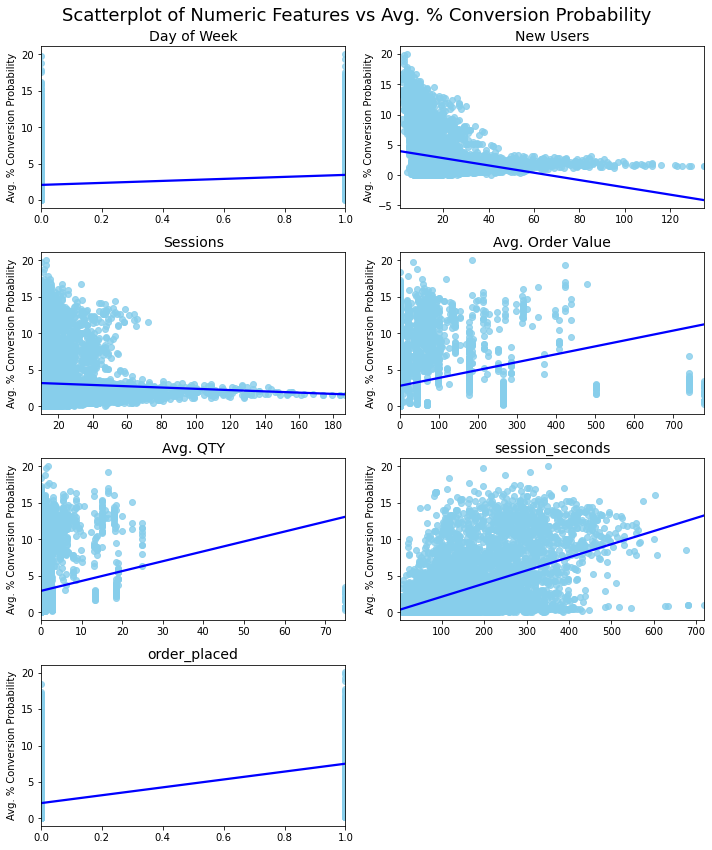

In [15]:
# There's a clear relationship between conversion rate and session length that we'll explore further on
eda_scatterplot(df, df.drop(columns='Avg. % Conversion Probability')._get_numeric_data().columns, 
                'Avg. % Conversion Probability')

## Boxplots of Categorical Features

### Source

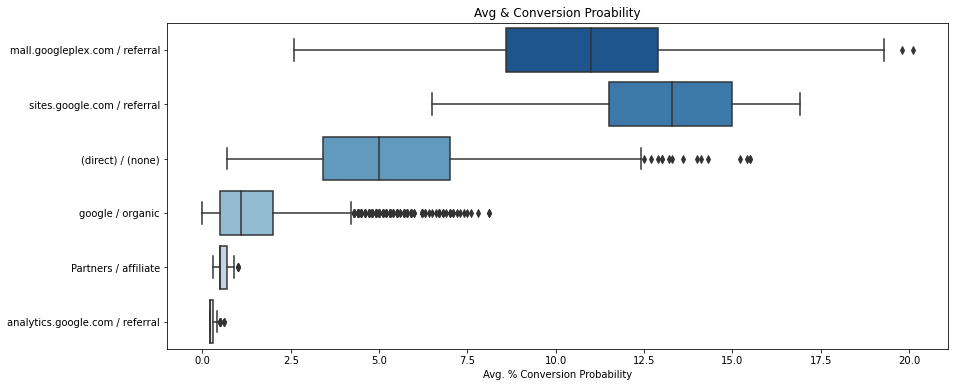

In [16]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x='Avg. % Conversion Probability', y='Source / Medium', palette='Blues_r')
plt.ylabel('')
plt.title('Avg & Conversion Proability');

### In-Market Segments

In [17]:
top_marketseg = df.groupby('In-Market Segment').sum().sort_values(by='Avg. Order Value', ascending=False)
top_marketseg = top_marketseg[['Avg. Order Value', 'Avg. % Conversion Probability']].head(15) \
                                                            .sort_values(by='Avg. % Conversion Probability', ascending=False)
top_marketseg.head(5)

,Avg. Order Value,Avg. % Conversion Probability
In-Market Segment,,
Business Services/Advertising & Marketing Services,14076.90,1865.3
Travel/Hotels & Accommodations,23468.12,1825.8
Travel/Air Travel,17112.70,1190.4
Employment,6674.91,1018.2
Apparel & Accessories/Women's Apparel,10948.43,894.8


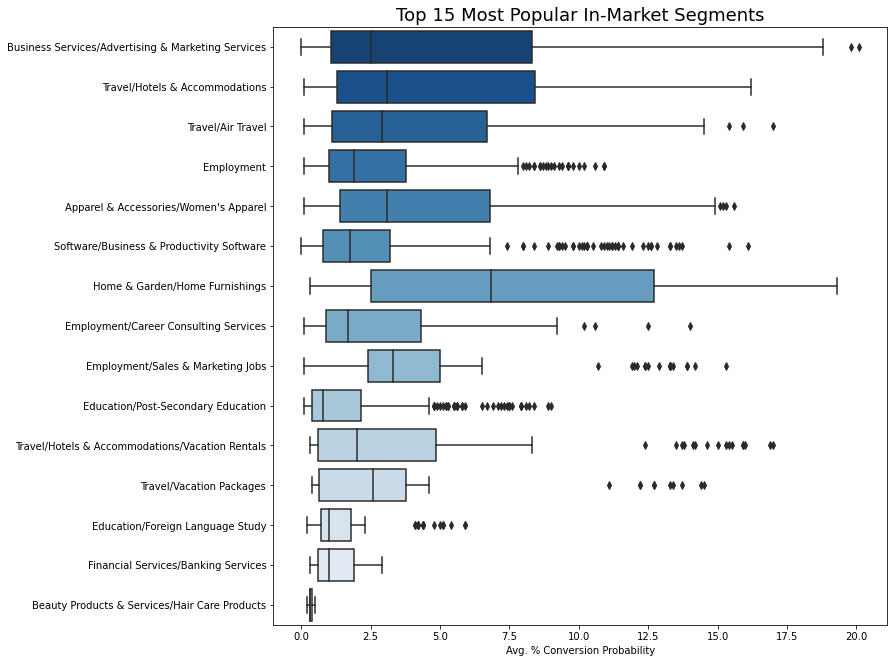

In [18]:
g_data = df[df['In-Market Segment'].isin(list(top_marketseg.index))].sort_values(by='Avg. % Conversion Probability', 
                                                                                 ascending=False)
plt.figure(figsize=(11,11))
sns.boxplot(data=g_data, 
            x='Avg. % Conversion Probability', y='In-Market Segment', palette='Blues_r', order=top_marketseg.index)
plt.ylabel('')
plt.title('Top 15 Most Popular In-Market Segments', fontsize=18);

### Affinity

In [19]:
top_affinity = df.groupby('Affinity Category (reach)').sum().sort_values(by='Avg. % Conversion Probability', ascending=False)
top_affinity = top_affinity[['Avg. Order Value', 'Avg. % Conversion Probability']].head(15) \
                                                            .sort_values(by='Avg. % Conversion Probability', ascending=False)
top_affinity.head(5)

,Avg. Order Value,Avg. % Conversion Probability
Affinity Category (reach),,
Shoppers/Value Shoppers,8533.59,1296.3
Technology/Technophiles,5874.33,1111.9
Media & Entertainment/Movie Lovers,8640.81,1087.2
Lifestyles & Hobbies/Business Professionals,8780.26,1066.3
Sports & Fitness/Health & Fitness Buffs,10002.30,976.8


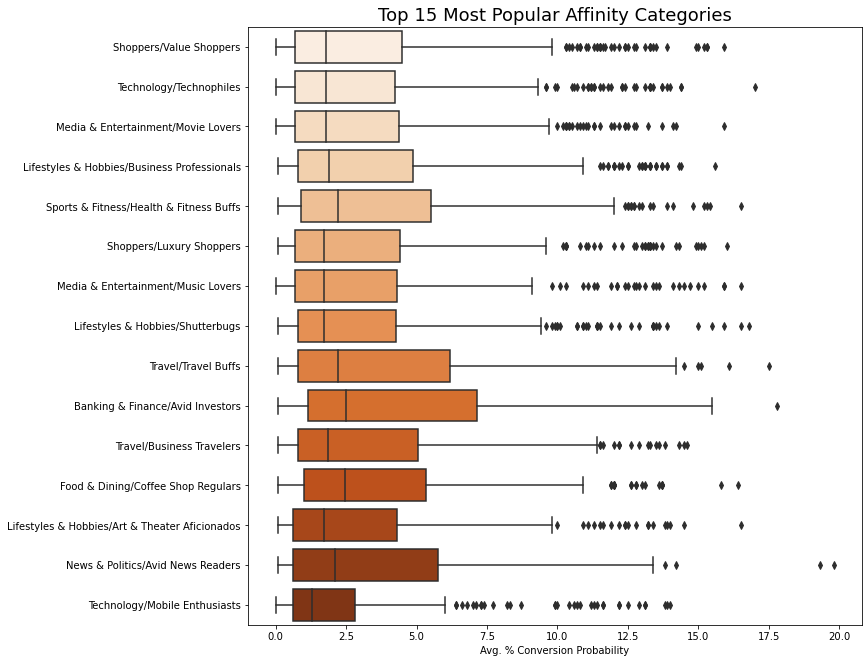

In [20]:
g_data = df[df['Affinity Category (reach)'].isin(list(top_affinity.index))].sort_values(by='Avg. % Conversion Probability', 
                                                                                 ascending=False)
plt.figure(figsize=(11,11))
sns.boxplot(data=g_data, 
            x='Avg. % Conversion Probability', y='Affinity Category (reach)', palette='Oranges', order=top_affinity.index)
plt.ylabel('')
plt.title('Top 15 Most Popular Affinity Categories', fontsize=18);

## Key Correlations

In [21]:
temp_df = pd.get_dummies(data=df, 
                         columns=['Device Category', 'In-Market Segment', 'Affinity Category (reach)', 'Source / Medium'],
                        prefix_sep=': ')

In [22]:
temp_df = temp_df.drop(columns='order_placed')

#### Avg. % Conversion Probability Correlation

In [23]:
temp_df.corr()['Avg. % Conversion Probability'].sort_values(ascending=False).head(15)

Avg. % Conversion Probability                                                              1.000000
Source / Medium: mall.googleplex.com / referral                                            0.750159
session_seconds                                                                            0.488784
Device Category: desktop                                                                   0.262934
Source / Medium: (direct) / (none)                                                         0.262382
Avg. Order Value                                                                           0.251874
Source / Medium: sites.google.com / referral                                               0.204572
Avg. QTY                                                                                   0.187506
Day of Week                                                                                0.173518
In-Market Segment: Home & Garden/Home Furnishings                                          0.150037


In [24]:
temp_df.corr()['Avg. % Conversion Probability'].sort_values(ascending=False).tail(5)

In-Market Segment: Education/Test Preparation & Tutoring   -0.071881
Source / Medium: analytics.google.com / referral           -0.080516
New Users                                                  -0.213589
Device Category: mobile                                    -0.262934
Source / Medium: google / organic                          -0.743399
Name: Avg. % Conversion Probability, dtype: float64

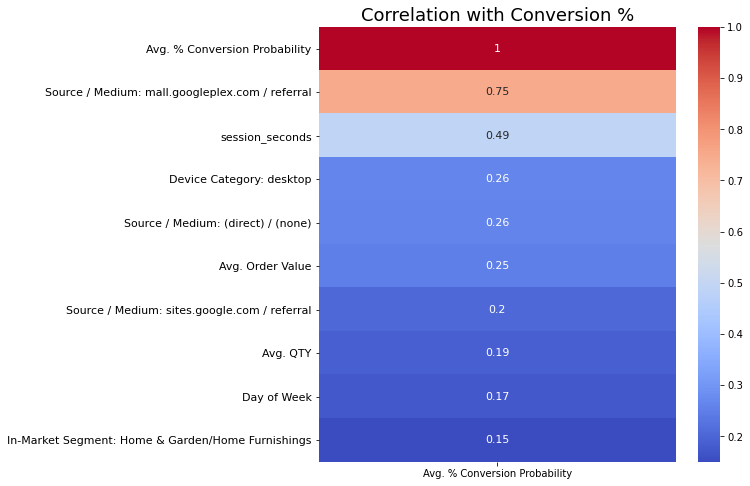

In [25]:
plt.figure(figsize=(8,8))
sns.heatmap(temp_df.corr()[['Avg. % Conversion Probability']].sort_values(ascending=False, 
                                                                          by='Avg. % Conversion Probability').head(10), 
                                                                          cmap='coolwarm', annot=True, annot_kws={"size":11})
plt.yticks(fontsize=11);
plt.title('Correlation with Conversion %', fontsize=18);

#### Avg. Order Value Correlation

In [26]:
temp_df.corr()['Avg. Order Value'].sort_values(ascending=False).head(15)

Avg. Order Value                                                    1.000000
Avg. QTY                                                            0.780327
Source / Medium: mall.googleplex.com / referral                     0.283739
Avg. % Conversion Probability                                       0.251874
session_seconds                                                     0.195557
In-Market Segment: Travel/Vacation Packages                         0.175149
Day of Week                                                         0.167717
Sessions                                                            0.135297
Device Category: desktop                                            0.114178
In-Market Segment: Education/Post-Secondary Education               0.104099
In-Market Segment: Travel/Hotels & Accommodations                   0.100988
In-Market Segment: Beauty Products & Services/Hair Care Products    0.092812
In-Market Segment: Home & Garden/Home Furnishings                   0.091809

In [27]:
temp_df.corr()['Avg. Order Value'].sort_values(ascending=False).tail(5)

In-Market Segment: Computers & Peripherals/Computers/Tablets & Ultraportable Devices   -0.038105
Affinity Category (reach): Media & Entertainment/Light TV Viewers                      -0.039376
In-Market Segment: Consumer Electronics/Mobile Phones                                  -0.046151
Device Category: mobile                                                                -0.114178
Source / Medium: google / organic                                                      -0.201861
Name: Avg. Order Value, dtype: float64

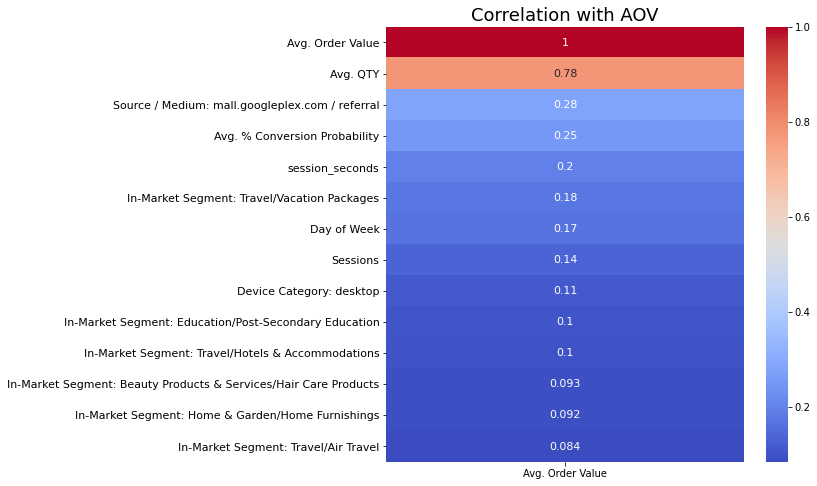

In [28]:
plt.figure(figsize=(8,8))
sns.heatmap(temp_df.corr()[['Avg. Order Value']].sort_values(ascending=False, 
                                                                          by='Avg. Order Value').head(14), 
                                                                          cmap='coolwarm', annot=True, annot_kws={"size":11})
plt.yticks(fontsize=11);
plt.title('Correlation with AOV', fontsize=18);

Given that `Source / Medium` has extremely strong correlations with `Avg. % Conversion Probability` and `Avg. Order Value`, most of our observations will be focused on the relationships between Source / Medium and our two target variables.

## Observation 1: Customers from Different Sources Spend Differently

Looking at the distribution of Average Order Value, we can see there's several 'peaks' or bimodality within the data.

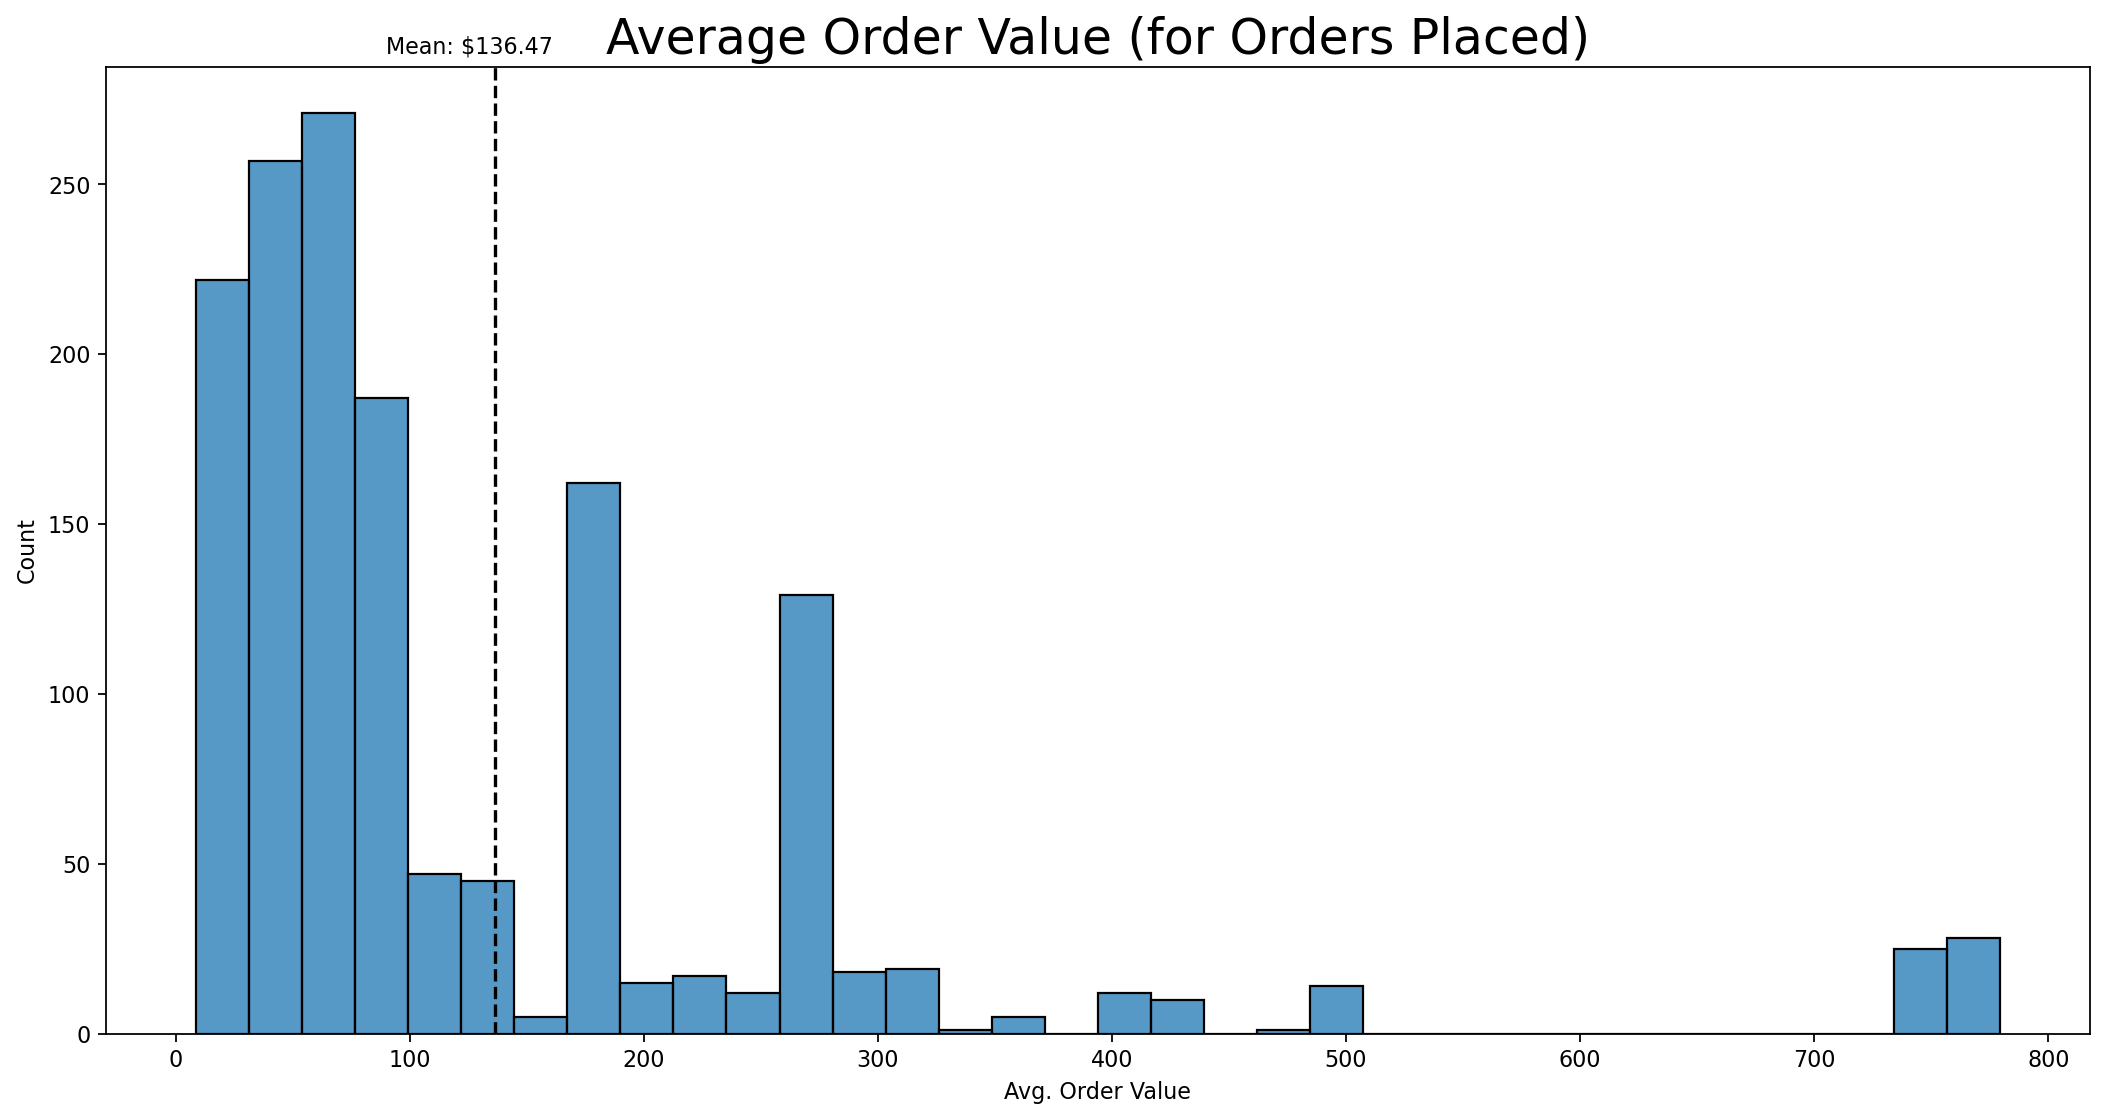

In [29]:
plt.figure(figsize=(16,8), dpi=160)
sns.histplot(data=df[df['Avg. Order Value'] > 0], x='Avg. Order Value', kde=False)
mean = df[df['Avg. Order Value'] > 0]['Avg. Order Value'].mean()
plt.axvline(mean, color='black', ls='--', label=f'Mean Value: ${mean:.2f}')
plt.text(90,288.5,f'Mean: ${mean:.2f}')
#plt.xticks(np.arange(10, 800, 30))
plt.title('Average Order Value (for Orders Placed)', fontsize=22);

This can be explained by different sources -- users from Google Mall tend to place cheaper orders, while users from direct links or the Google search engine tend to place more expensive orders.

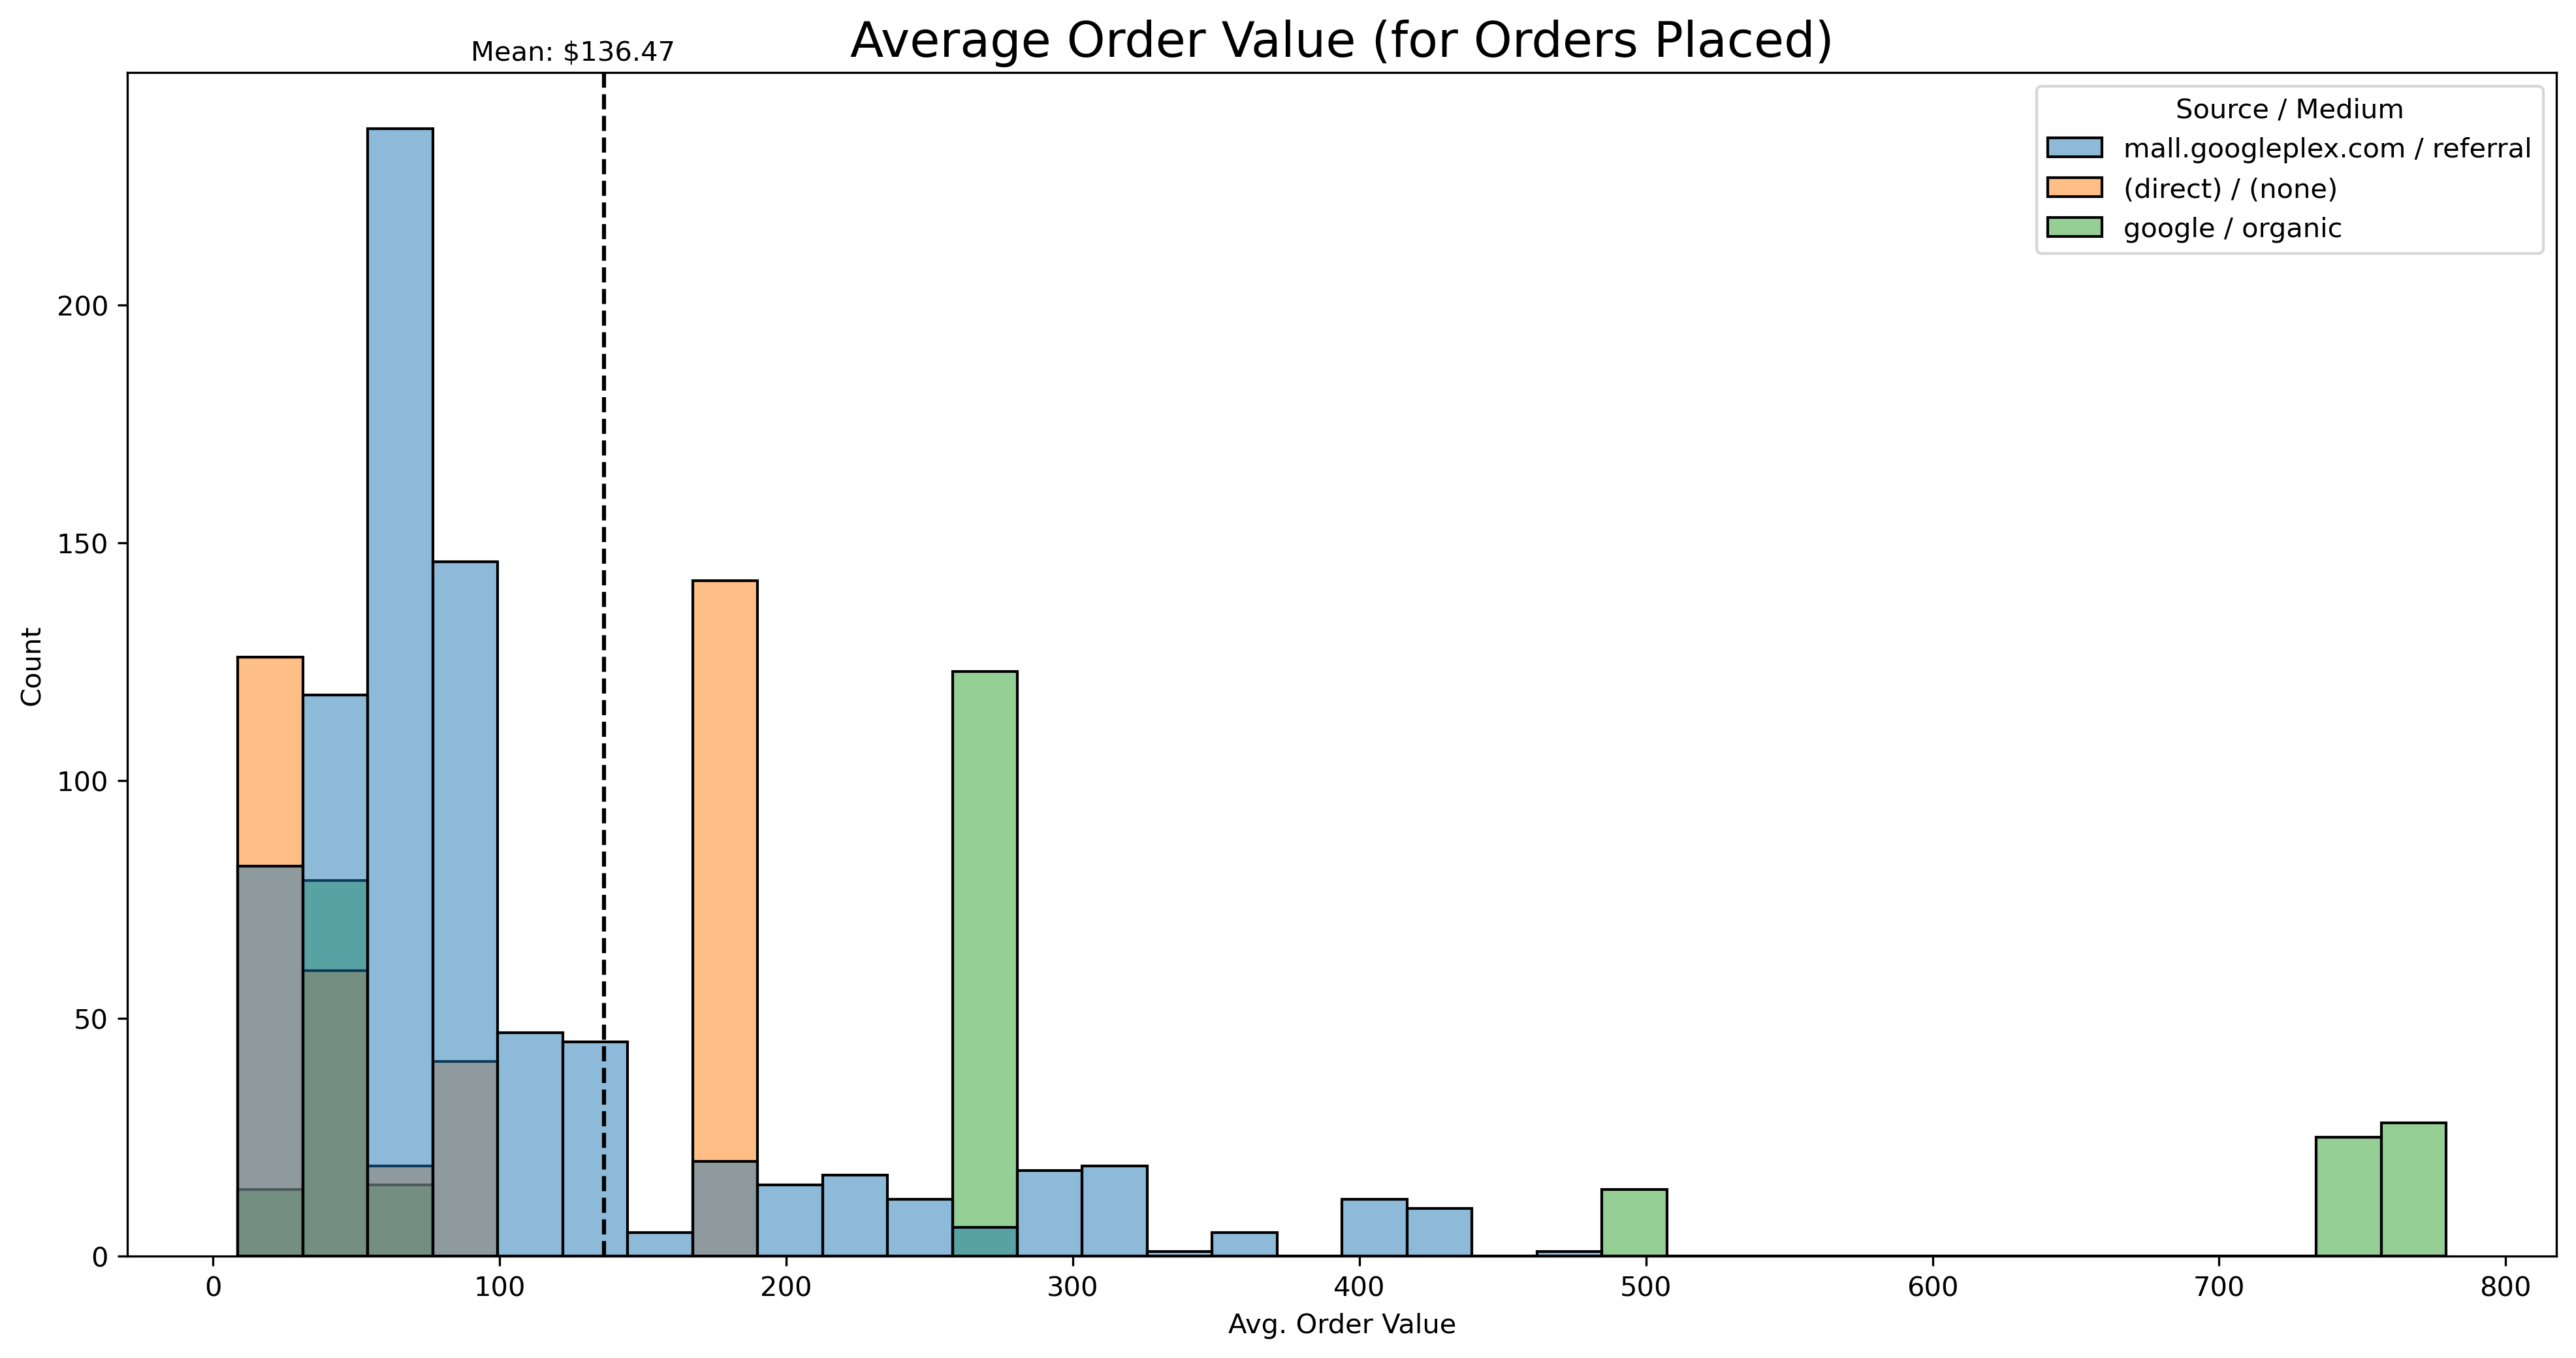

In [30]:
plt.figure(figsize=(16,8), dpi=300)
sns.histplot(data=df[df['Avg. Order Value'] > 0], x='Avg. Order Value', hue='Source / Medium', palette='tab10')
mean = df[df['Avg. Order Value'] > 0]['Avg. Order Value'].mean()
plt.axvline(mean, color='black', ls='--', label=f'Mean Value: ${mean:.2f}')
plt.text(90,251.5,f'Mean: ${mean:.2f}')
#plt.legend()
#plt.xticks(np.arange(8, 800, 30), rotation=45)
plt.title('Average Order Value (for Orders Placed)', fontsize=18);

### Group 1: AOV (Less than $120)

In [31]:
# Group 1: Budget Travellers, Students, Education/Business, Home Shoppers
df[(df['Avg. Order Value'] < 120) & (df['Avg. Order Value'] != 0)] \
['In-Market Segment'].value_counts().head(15)

Travel/Hotels & Accommodations                               99
Travel/Air Travel                                            91
Employment                                                   60
Financial Services/Investment Services                       59
Consumer Electronics/Mobile Phones                           58
Employment/Career Consulting Services                        53
Home & Garden/Home Decor                                     53
Software/Business & Productivity Software                    44
Employment/IT & Technical Jobs                               42
Business Services/Advertising & Marketing Services           34
Computers & Peripherals/Computers/Laptops & Notebooks        34
Education/Post-Secondary Education                           31
Home & Garden/Home Furnishings                               28
Computers & Peripherals/Computer Accessories & Components    28
Autos & Vehicles/Motor Vehicles/Motor Vehicles (Used)        24
Name: In-Market Segment, dtype: int64

In [32]:
# Group 1: Casual Hobbyists, Budget Travellers, Shoppers
df[(df['Avg. Order Value'] < 120) & (df['Avg. Order Value'] != 0)]['Affinity Category (reach)'].value_counts().head(10)

Shoppers/Value Shoppers                           57
Technology/Technophiles                           53
Media & Entertainment/Movie Lovers                49
Banking & Finance/Avid Investors                  41
Sports & Fitness/Health & Fitness Buffs           40
Lifestyles & Hobbies/Shutterbugs                  39
Shoppers/Luxury Shoppers                          38
Lifestyles & Hobbies/Business Professionals       37
Travel/Travel Buffs                               36
Lifestyles & Hobbies/Art & Theater Aficionados    33
Name: Affinity Category (reach), dtype: int64

In [33]:
# Group 1: Mostly people from Google Mall
df[(df['Avg. Order Value'] < 120) & (df['Avg. Order Value'] != 0)]['Source / Medium'].value_counts().head()

mall.googleplex.com / referral    628
(direct) / (none)                 246
google / organic                  108
Name: Source / Medium, dtype: int64

### Group 2: AOV ~$180

In [34]:
# Group 2: Job Seekers, Employers, Real Estate
df[(df['Avg. Order Value'] > 160) & (df['Avg. Order Value'] < 210)]['In-Market Segment'].value_counts().head(10)

Business Services/Advertising & Marketing Services                      27
Software/Business & Productivity Software                               23
Employment/Sales & Marketing Jobs                                       22
Real Estate/Residential Properties                                      22
Employment                                                              11
Employment/Career Consulting Services                                   10
Real Estate/Residential Properties/Residential Properties (For Sale)    10
Travel/Air Travel                                                        8
Employment/IT & Technical Jobs                                           6
Business Services/Business Financial Services                            6
Name: In-Market Segment, dtype: int64

In [35]:
# Group 2: Average people, casual users
df[(df['Avg. Order Value'] > 160) & (df['Avg. Order Value'] < 210)]['Affinity Category (reach)'].value_counts().head()

Technology/Mobile Enthusiasts                                                  11
Sports & Fitness/Sports Fans                                                   11
Vehicles & Transportation/Auto Enthusiasts                                      9
Lifestyles & Hobbies/Business Professionals                                     9
Food & Dining/Frequently Dines Out/Diners by Meal/Frequently Eats Lunch Out     9
Name: Affinity Category (reach), dtype: int64

In [36]:
# Group 2: Mostly people with a direct link
df[(df['Avg. Order Value'] > 160) & (df['Avg. Order Value'] < 210)]['Source / Medium'].value_counts()

(direct) / (none)                 142
mall.googleplex.com / referral     24
Name: Source / Medium, dtype: int64

### Group 3: AOV ~275

In [37]:
# Group 3: High-end female shoppers, Students, Travellers
df[(df['Avg. Order Value'] > 250) & (df['Avg. Order Value'] < 300)]['In-Market Segment'].value_counts().head(15)

Apparel & Accessories/Women's Apparel                 23
Financial Services/Banking Services                   21
Education/Foreign Language Study                      20
Travel/Hotels & Accommodations/Vacation Rentals       19
Beauty Products & Services/Hair Care Products         15
Education/Post-Secondary Education                    14
Telecom/Internet Service Providers                    14
Education/Primary & Secondary Schools (K-12)          11
Travel/Hotels & Accommodations                        11
Business Services/Advertising & Marketing Services     7
Telecom/Cable & Satellite TV Providers                 2
Name: In-Market Segment, dtype: int64

In [38]:
# Group 3: Job seekers, Employers, Real Estate
df[(df['Avg. Order Value'] > 250) & (df['Avg. Order Value'] < 300)]['Affinity Category (reach)'].value_counts().head()

Lifestyles & Hobbies/Art & Theater Aficionados                   9
News & Politics/Avid News Readers/Avid Political News Readers    9
Shoppers/Value Shoppers                                          9
Banking & Finance/Avid Investors                                 9
Technology/Technophiles                                          8
Name: Affinity Category (reach), dtype: int64

In [39]:
# Group 3: Mostly organic
df[(df['Avg. Order Value'] > 250) & (df['Avg. Order Value'] < 300)]['Source / Medium'].value_counts().head()

google / organic                  123
mall.googleplex.com / referral     34
Name: Source / Medium, dtype: int64

### Group 4: AOV ~$800

In [40]:
# Group 4: Travellers
df[df['Avg. Order Value'] > 700]['In-Market Segment'].value_counts()

Travel/Vacation Packages              16
Education/Post-Secondary Education    14
Travel/Air Travel                     14
Travel/Hotels & Accommodations         9
Name: In-Market Segment, dtype: int64

In [41]:
# Group 4: Hobbyists
df[df['Avg. Order Value'] > 700]['Affinity Category (reach)'].value_counts().head(5)

Media & Entertainment/Book Lovers                 4
Lifestyles & Hobbies/Art & Theater Aficionados    3
Media & Entertainment/Music Lovers                3
Sports & Fitness/Health & Fitness Buffs           3
Travel/Travel Buffs                               3
Name: Affinity Category (reach), dtype: int64

In [42]:
# Group 4: Only organic
df[df['Avg. Order Value'] > 700]['Source / Medium'].value_counts()

google / organic    53
Name: Source / Medium, dtype: int64

## Observation 2: There's a positive relationship between Session Length & Conversion Rate

Text(0.5, 1.0, 'Session Length vs Conversion %')

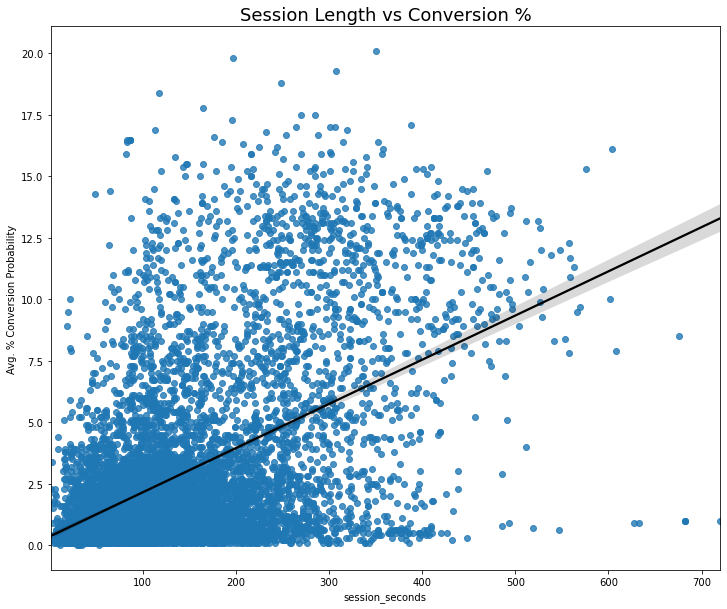

In [43]:
# Overall, the more time spent on site, the higher probability of conversion
plt.figure(figsize=(12,10))
sns.regplot(data=df, x='session_seconds', y='Avg. % Conversion Probability', line_kws={'color':'black'})
plt.title('Session Length vs Conversion %', fontsize=18)

In [44]:
# There's a moderate correlation between these two variables -- introducing flash sales might help
df.corr()['Avg. % Conversion Probability']['session_seconds']

0.4887840525816859

In [45]:
sources = ['google / organic', '(direct) / (none)',
       'mall.googleplex.com / referral',
       'sites.google.com / referral']

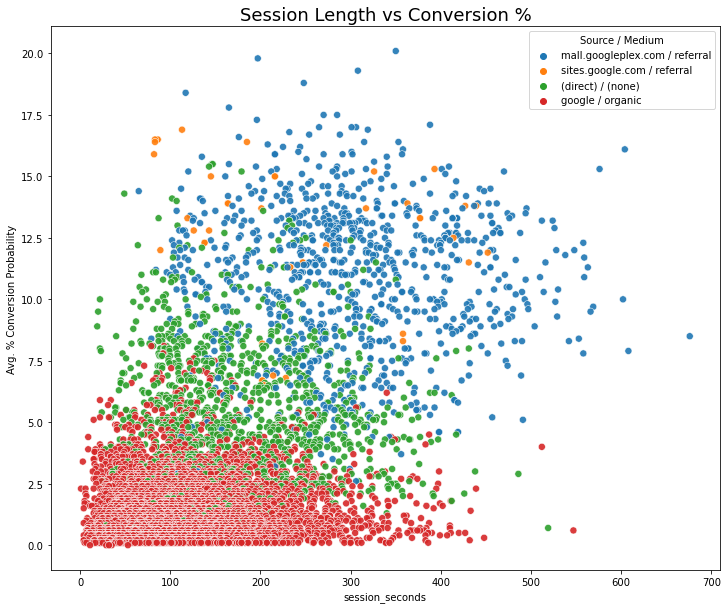

In [46]:
# Users from different sources also tend to spend different amounts of time on the site
plt.figure(figsize=(12,10))
sns.scatterplot(data=df[df['Source / Medium'].isin(list(sources))], 
                x='session_seconds', y='Avg. % Conversion Probability', hue='Source / Medium', s=50, alpha=0.9)
plt.title('Session Length vs Conversion %', fontsize=18);

In [47]:
df[df['Source / Medium'] == 'mall.googleplex.com / referral']['session_seconds'].mean()

298.8907922912206

In [48]:
df[df['Source / Medium'] == 'google / organic']['session_seconds'].mean()

120.73652892561984

## Observation 3: In-Market Segments need to be re-targeted

In [49]:
orderval_df = df.groupby('In-Market Segment').sum().sort_values(by='Avg. Order Value', ascending=False)
orderval_df = orderval_df[['Avg. Order Value', 'Avg. % Conversion Probability', 'Avg. QTY']].head(7) \
                                                            .sort_values(by='Avg. Order Value', ascending=False)
orderval_df.head(7)

,Avg. Order Value,Avg. % Conversion Probability,Avg. QTY
In-Market Segment,,,
Travel/Hotels & Accommodations,23468.12,1825.8,790.00
Education/Post-Secondary Education,17169.01,418.2,1274.40
Travel/Air Travel,17112.70,1190.4,1270.11
Business Services/Advertising & Marketing Services,14076.90,1865.3,459.98
Travel/Vacation Packages,12442.05,240.3,336.74
Apparel & Accessories/Women's Apparel,10948.43,894.8,328.48
Home & Garden/Home Furnishings,9767.14,829.2,559.40


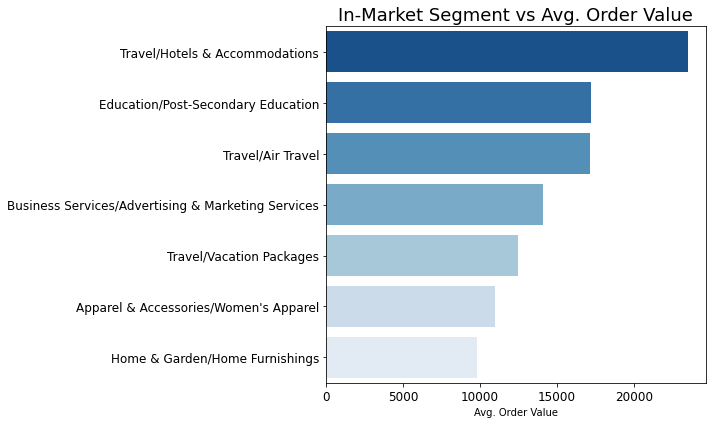

In [50]:
plt.figure(figsize=(10, 6))
sns.barplot(data=orderval_df, y=orderval_df.index, x='Avg. Order Value', 
            palette='Blues_r')
plt.title('In-Market Segment vs Avg. Order Value', fontsize=18);
plt.ylabel('')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout();